# Working with Celestial Coordinates in WCS 1: Specifying, reading, and plotting

## Authors

Kris Stern, Kelle Cruz, Lia Corrales, David Shupe, Adrian Price-Whelan

## Learning Goals

1. Demonstrate two ways to build a `astropy.wcs.WCS` object
2. Show an image of the Helix nebula with RA and Dec labeled
3. Plot a scale bar on an image with WCS information

## Keywords

WCS, coordinates, matplotlib

## Companion Contents
1. "An Introduction to Modern Astrophysics" ([Carroll & Ostlie](https://ui.adsabs.harvard.edu/abs/2006ima..book.....C/abstract))
2. [FITS WCS page at GSFC](https://fits.gsfc.nasa.gov/fits_wcs.html)

## Summary

This tutorial series aims to show how the content of Chapter 1 of "An Introduction to Modern Astrophysics" by Carroll and Ostlie can be applied to real life astrophysics research situations, using tools in the Astropy ecosystem. We will introduce two different approaches to building a `astropy.wcs.WCS` object, which contains meta-data that (in this case) defines a mapping between image coordinates and sky coordinates. The `astropy.wcs` subpackage conforms to the standards of the FITS World Coordinate System (WCS) used extensively by the astronomy research community. We will created a 2D WCS for an image of the iconic the Helix nebula (a planetary nebula) and display an image of the nebula with sky coordinates (here, equatorial, ICRS RA and Dec.) labeled. Finally, we will over-plot a scale bar on the Helix nebula image using WCS to give the reader a sense of the angular size of the image.

In [1]:
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt

## Section 1: Two ways to create an `astropy.wcs.WCS` object

*World coordinates* serve to locate a measurement in some multi-dimensional parameter space. A World Coordinate System (WCS) specifies the physical, or world, coordinates to be attached to each pixel or voxel of an N-dimensional image or array. An [elaborate set of standards and conventions](https://fits.gsfc.nasa.gov/fits_wcs.html) have been developed for the Flexible Image Transport System (FITS) format ([Wells et al. 1981](https://ui.adsabs.harvard.edu/abs/1981A&AS...44..363W/abstract)). A typical WCS example is to specify the Right Ascension (RA) and Declination (Dec) on the sky associated with a given the pixel or spaxel location in a 2-dimensional celestial image ([Greisen & Calabretta 2002](https://ui.adsabs.harvard.edu/abs/2002A&A...395.1061G/abstract); [Calabretta and Greisen 2002](https://ui.adsabs.harvard.edu/abs/2002A&A...395.1077C/abstract)).

The [`astropy.wcs` subpackage](https://docs.astropy.org/en/stable/wcs/) implements FITS standards and conventions for World Coordinate Systems. Using the `astropy.wcs.WCS` object and `matplotlib`, we can generate images of the sky that have axes labeled with coordinates such as right ascension (RA) and declination (Dec). This requires selecting the proper projections for `matplotlib` and providing an `astropy.visualization.WCSAxes` object.

There are two main ways to initialize a `WCS` object: with a Python dictionary (or dictionary-like object, like a FITS file header) or with Python lists. In this set of examples, we will initialize an `astropy.wcs.WCS` object with two dimensions, as would be needed to represent an image.

The WCS standard defines a set of keywords that are used to represent the world coordinate system for a given set of data (e.g., image). Here is a list of the essential WCS keywords and their uses; In each case, the integer $n$ denotes the dimensional axis (starting with 1) to which the keyword is being applied. In our examples below, we will have two image dimensions (axes), so $n$ will either be 1 or 2.

* **CRVALn**: the coordinate value at a reference point (e.g., RA and DEC value in degrees)
* **CRPIXn**: the pixel location of the reference point (e.g., CRPIX1=1, CRPIX2=1 describes the center of a corner pixel)
* **CDELTn**: the coordinate increment at the reference point (e.g., the difference in 'RA' value from the reference pixel to its neighbor along the RA axis)
* **CTYPEn**: an 8-character string describing the axis type (e.g., 'RA---TAN' and 'DEC---TAN' describe the typical tangent-plane sky projection that astronomers use)
* **CUNITn**: a string describing the unit for each axis (if not specified, the default unit is degrees.)
* **NAXISn**: an integer defining the number of pixels in each axis

Some good references of the WCS standard can be found [here](https://fits.gsfc.nasa.gov/fits_wcs.html).

### Method 1: Building a WCS object with a dictionary

One way to define an Astropy `WCS` object is to construct a dictionary containing all of the essential information (i.e., specifying values for the WCS keywords listed above) that map the pixel coordinate space to the world coordinate space. 

In this example, we define two coordinate axes with:
* A Gnomonic (tangent-plane) projection, which corresponds to the RA/Dec coordinate system
* A reference location of (RA,DEC) = (337.52, -20.83), as defined by the **CRVALn** keys
* The pixel at coordinate value (1,1) as the reference location (**CRPIXn** keys)
* Units of degrees (**CUNITn = 'deg'**)
* Pixel sizes of 1 x 1 arcsec (**CDELTn = 0.002778** in degrees)
* An image size of 1024 x 1024 pixels (**NAXISn** key)

In [2]:
wcs_input_dict = {
    'CTYPE1': 'RA---TAN', 
    'CUNIT1': 'deg', 
    'CDELT1': -0.0002777777778, 
    'CRPIX1': 1, 
    'CRVAL1': 337.5202808, 
    'NAXIS1': 1024,
    'CTYPE2': 'DEC--TAN', 
    'CUNIT2': 'deg', 
    'CDELT2': 0.0002777777778, 
    'CRPIX2': 1, 
    'CRVAL2': -20.833333059999998, 
    'NAXIS2': 1024
}
wcs_helix_dict = WCS(wcs_input_dict)

Now let's print the `WCS` object defined with a Python dictionary to check its content: 

In [3]:
wcs_helix_dict # To check output

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 337.5202808  -20.83333306  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0002777777778  0.0002777777778  
NAXIS : 1024  1024

In this demonstration (and below), we assume that we know all of the relevant WCS keyword values to specify. Typically, however, we will rely on software to produce these values for us. For example, WCS information is most often included automatically in FITS files produced by software used to take images with most instruments at astronomical observatories. In cases when the WCS information is provided for us in a FITS file, it is typically included in a FITS header, which, when read into Python, acts like a dictionary object. We demonstrate this later on in this tutorial.

### Method 2: Create an empty WCS object before assigning values

Alternatively, we could initialize the `astropy.wcs.WCS` object, and assign the keyword values with lists corresponding to each respective axis.

In [4]:
wcs_helix_list = WCS(naxis=2)
wcs_helix_list.wcs.crpix = [1, 1]
wcs_helix_list.wcs.crval = [337.5202808, -20.833333059999998]
wcs_helix_list.wcs.cunit = ["deg", "deg"]
wcs_helix_list.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs_helix_list.wcs.cdelt = [-0.0002777777778, 0.0002777777778]

Let's print the `WCS` object one more time to check how our values were assigned.

In [5]:
wcs_helix_list # To check output

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 337.5202808  -20.833333059999998  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0002777777778  0.0002777777778  
NAXIS : 0  0

Note that when we initialize the WCS object this way, the `NAXIS` values are set to 0. To assign coordinates to our image, we will need to fix the shape of the `WCS` object array so that it matches our image. We can do this by assigning a value to the `array_shape` attribute of the `WCS` object:

In [6]:
wcs_helix_list.array_shape = [1024, 1024]

Now when we print the `WCS` object, we can see that the `NAXIS` values have been updated from the default size of 0 to 1024.

In [7]:
wcs_helix_list

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 337.5202808  -20.833333059999998  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0002777777778  0.0002777777778  
NAXIS : 1024  1024

## Section 2: Show an image of the Helix nebula with RA and Dec labeled

Most of the time we can obtain the required `astropy.wcs.WCS` object from the header of the FITS file from a telescope or astronomical database. This process is described below.

### Step 1: Read in the FITS file

We will read the FITS file containing an image of the Helix nebula from the `astropy-data` GitHub repository using the `astropy.io.fits` subpackage. The `astropy.io.fits.open()` function will load the contents of a FITS file into Python, and it accepts either a local file path or a URL (as is demonstrated here). This image (FITS file) was originally accessed from the [Digitized Sky Survey](https://archive.eso.org/dss/dss) but is provided in the `astropy-data` repository for convenience:

In [8]:
header_data_unit_list = fits.open('https://github.com/astropy/astropy-data/raw/6d92878d18e970ce6497b70a9253f65c925978bf/tutorials/celestial-coords1/tailored_dss.22.29.38.50-20.50.13_60arcmin.fits')

FITS files are a binary file format that is mainly used by astronomers and can contain information arranged in many "extensions," which contain both header information (e.g., metadata) and data (e.g., image data). We can check how many extensions there are in a FITS file, as well as view a summary of the contents in each extension, by printing the FITS object information.

In [9]:
header_data_unit_list.info()

Filename: /home/runner/.astropy/cache/download/url/21d072715b8ee90ab2fe1405b0e5fb1a/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     121   (2119, 2119)   int16   


This shows us that our FITS file contains only one extension, labeled 'PRIMARY' (or extension number 0). We will copy the image data from this extension to the variable `image`, and the header data to the variable `header`:

In [10]:
image = header_data_unit_list[0].data
header = header_data_unit_list[0].header

We can print the FITS image header to screen so that all of its contents can be checked or utilized. Note that the WCS information for this information can be found near the bottom of the printed header, below.

In [11]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2119                                                  
NAXIS2  =                 2119                                                  
DATE    = '03/09/19          ' /Date of FITS file creation                      
ORIGIN  = 'CASB -- STScI     ' /Origin of FITS image                            
PLTLABEL= 'J 10265           ' /Observatory plate label                         
PLATEID = '04I5              ' /GSSS Plate ID                                   
REGION  = 'S602              ' /GSSS Region Name                                
DATE-OBS= '1985-06-15'         / UT date of Observation                         
UT      = '18:30:00.00       ' /UT time of observation                          
EPOCH   =  1.9854542236328E+

Please note that the *original* header (as downloaded from the DSS) violates the FITS WCS standards (because it includes both CDELTn keywords and a matrix of CD values; including deprecated PC-matrix keywords). The header has been cleaned up to conform to the existing standards.

### Step 2: Read in the FITS image coordinate system with astropy.wcs.WCS

Because the header contains WCS information and acts like a Python dictionary, an Astropy `WCS` object can be created directly from the FITS header.

In [12]:
wcs_helix = WCS(header)

Let's print the `WCS` object to see what values were drawn from the header.

In [13]:
wcs_helix

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 336.6811440416667  -19.745016572222223  
CRPIX : 2499.6447489941065  3378.9002584168584  
PC1_1 PC1_2  : 0.025282857855146917  4.4684674035885186e-05  
PC2_1 PC2_2  : -4.8420685266167345e-05  0.0252859566668733  
CDELT : -0.01867333422948538  0.01867333422948538  
NAXIS : 2119  2119

### Step 3: Plot the Helix nebula with sky coordinate axes (RA and Dec)

The image data, `image`, is a 2D array of values, and by itself contains no information about the sky coordinates of the pixels. So, if we plotted the image by itself, the plot axes would show pixel values. (We will be using the `matplotlib` library for the plotting.)

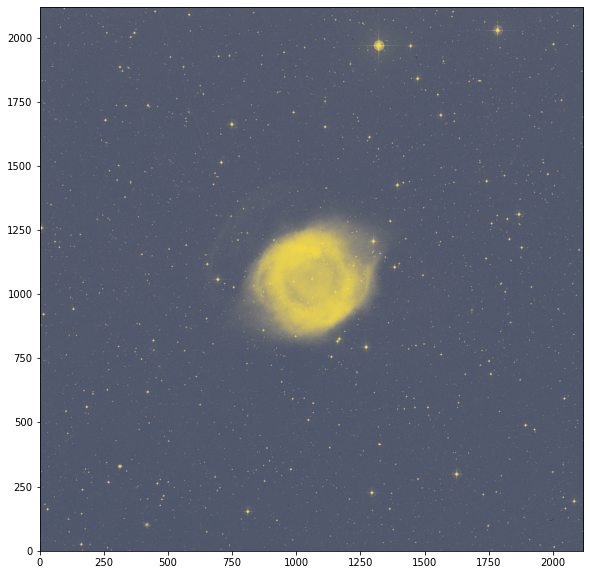

In [14]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(image, origin='lower', cmap='cividis')

All of the information that maps from these pixel values to sky coordinates comes from the WCS metadata, which we loaded into the `wcs_helix` object (from the FITS file header). This `WCS` object is built so that it can be provided to `matplotlib` with the  `projection` keyword, as shown in the call to `matplotlib.pyplot.subplot` below, in order to produce axes that show sky coordinate information instead of pixel values. We will also overlay a coordinate grid in ICRS equatorial coordinates by passing the sky coordinate frame name (here, "icrs") to the `ax.get_coords_overlay()` method.

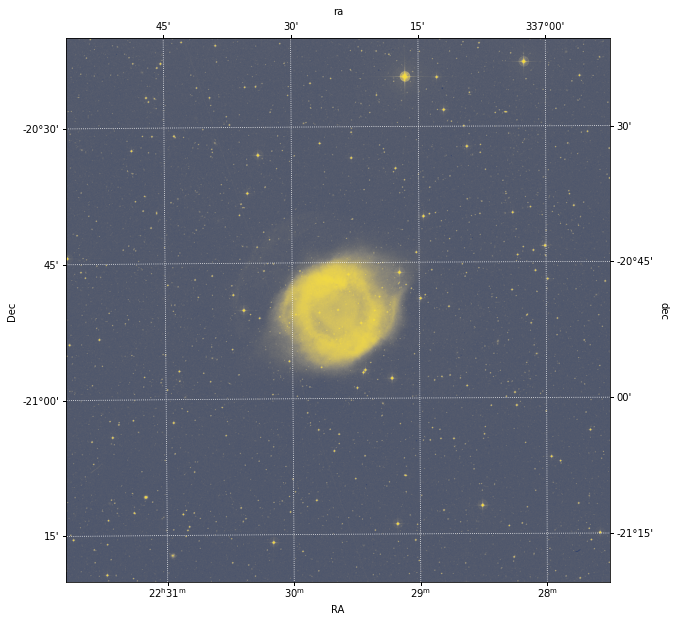

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

## Exercise

Copy the code block above and instead overlay a coordinate grid in Galactic coordinates.

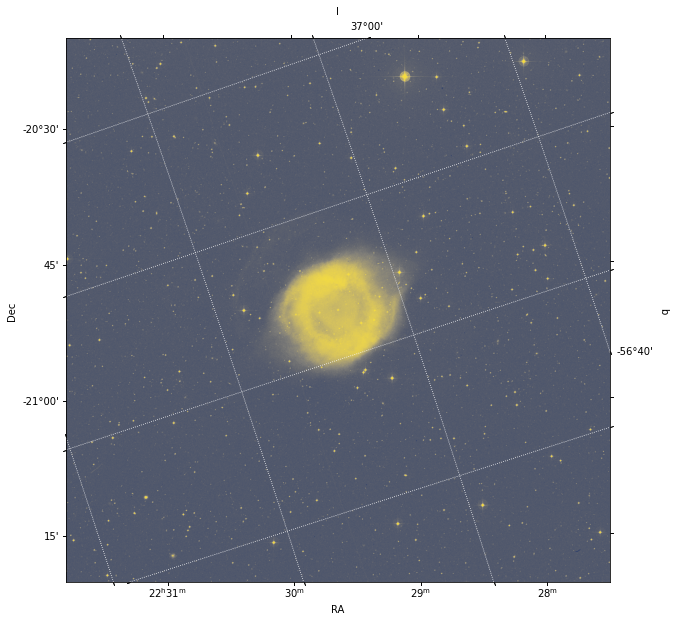

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')

## Section 3: Plot a scale marker on an image with WCS

To add a scale marker (i.e., a line of a particular *angular* size) to the image of the Helix nebula, we will use the matplotlib `Axes.arrow` method to draw a line. 

First, we need to decide where to place the scale bar. In the example below, we define the center of the scale marker to be at `(RA, Dec) = (337 deg, -21.2 deg)`. 

We then use the `transform` attribute of `Axes.arrow` to draw our scale bars in degrees (instead of pixel coordinates). In this case, we draw a scale marker with a length of 0.1 degrees. The arrow method inputs are `ax.arrow(x, y, dx, dy, **kwargs)`, with `x` and `y` being the `RA` and `Dec` of the beginning of the line. We use `dx=0` so that there is no horizontal component in the bar, and `dy=0.1`, which gives the length of the arrow in the vertical direction. To ensure that the arrow is drawn in the J2000 ICRS coordinate frame, we pass `ax.get_transform('icrs')` to the `transform` keyword.

Finally, we use `matplotlib.pyplot.text` to mark the length of the scale marker.

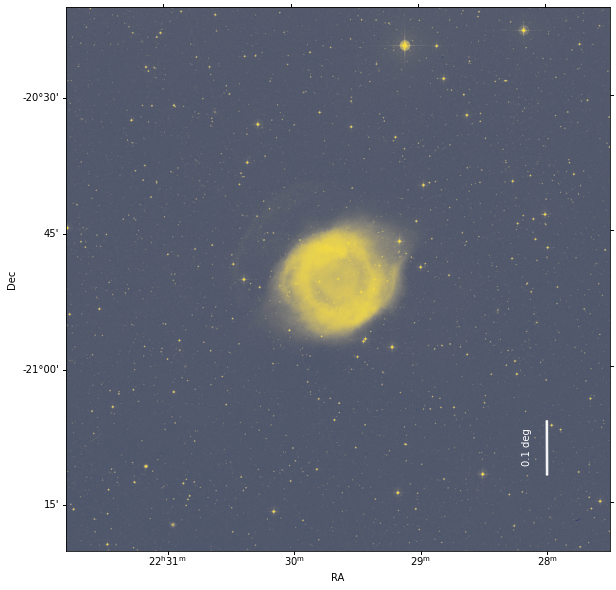

In [17]:
fig = plt.figure(figsize=(10, 10), frameon=False)
ax = plt.subplot(projection=wcs_helix)
ax.arrow(337, -21.2, 0, 0.1, 
         head_width=0, head_length=0, 
         fc='white', ec='white', width=0.003, 
         transform=ax.get_transform('icrs'))
plt.text(337.05, -21.18, '0.1 deg', 
         color='white', rotation=90, 
         transform=ax.get_transform('icrs'))
plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

## Exercise

Make a horizontal bar with the same length. Keep in mind that 1 hour angle = 15 degrees.